<a href="https://colab.research.google.com/github/hillwalking/2025-2-Data-Analysis/blob/main/ecomileage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,273 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and dire

In [10]:
# @title 서울시 에코마일리지 에너지 사용량 개인유형

import requests
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## 시각화 패키지와 한글 폰트 지정
plt.rc('font', family = 'NanumBarunGothic')

# pandas display option 조정
pd.set_option("display.max_rows", 10)
pd.set_option('display.max_colwidth',1000)
np.set_printoptions(precision=1, suppress=False)

url = 'http://openapi.seoul.go.kr:8088/6f546371447a6e6f3531544a726b62/json/energyUseDataSummaryInfo/1/1000'

response = requests.get(url)

if response.status_code == 200:
    print('API 호출 성공')
    # json data 저장
    data = response.json()
    # data 확인- 1
    print(type(data), ' , data length :  ', len(data))

else:
    print(f'API 호출 실패 : {response.status_code}')
#data

# json data 딕셔녀리 형태 확인{'energyUseDataSummaryInfo': {'list_total_count', 'RESULT', 'row' }
# 필요한 row 만 추출 저장함
data = data['energyUseDataSummaryInfo']['row']

# json data를 파일로 저장하기
with open('ecoSeoul.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=4, ensure_ascii = False)

# 데이터프레임으로 변환
df = pd.DataFrame(data)
#df.info()
#print('\n---DataFrame -----\n',df.head(3))

# 필요한 컬럼만 선택
df = df.loc[:,['YEAR','MON','EUS','GUS','WUS','HUS','MM_TYPE']]

# 개인 유형 데이터 추출한 후, 'MM_TYPE' 삭제
df_p = df.loc[df['MM_TYPE']=='개인']
df_p = df_p.drop(['MM_TYPE'], axis=1)

# 데이터를 숫자형으로 변환하기
df_p['YEAR'] = df_p['YEAR'].apply(lambda  x: int(x))
df_p['MON'] = df_p['MON'].apply(lambda  x: int(x))
df_p['EUS'] = df_p['EUS'].apply(lambda  x: float(x))
df_p['GUS'] = df_p['GUS'].apply(lambda  x: float(x))
df_p['WUS'] = df_p['WUS'].apply(lambda  x: float(x))
df_p['HUS'] = df_p['HUS'].apply(lambda  x: float(x))

# 2015년부터 2024년까지 행 추출
df_p = df_p[(df_p['YEAR'] > 2014) & (df_p['YEAR'] < 2025)]

# 인덱스 정리
df_p = df_p.reset_index(drop=True)

#print('\n----  2-1 ----\n')
#print(df.head(3))

# 월 범위에 따라 계절 지정하기
df_p.loc[(df_p['MON'] ==3) | (df_p['MON'] ==4) | (df_p['MON'] ==5), 'SEASON'] = '봄'
df_p.loc[(df_p['MON'] ==6) | (df_p['MON'] ==7) | (df_p['MON'] ==8), 'SEASON'] = '여름'
df_p.loc[(df_p['MON'] ==9) | (df_p['MON'] ==10) | (df_p['MON'] ==11), 'SEASON'] = '가을'
df_p.loc[(df_p['MON'] ==1) | (df_p['MON'] ==2) | (df_p['MON'] ==12), 'SEASON'] = '겨울'

#컬럼명 한글로 바꾸기
df_p= df_p.rename(columns={'YEAR':'연도', 'MON':'월', 'EUS':'전기', 'GUS':'가스', 'WUS':'수도', 'HUS':'지역난방', 'SEASON':'계절'})
print('\n----  2-2 -----\n',df_p.head(3))

# 계산할 컬럼으로 부분 데이터프레임으로 만든다.
df_sub = df_p.loc[:,['연도','전기', '가스', '수도', '지역난방']]
df_sub

# 연도를 기준으로 groupby  sum 하면 연도별 항목별 열합계 프레임
df_year = df_sub.groupby('연도').sum()

# 연도별로 에너지항목 행합계 추가
df_year['합계'] = df_year.sum(axis=1)
df_year = df_year.reset_index(drop=False)

df_year

API 호출 성공
<class 'dict'>  , data length :   1

----  2-2 -----
      연도   월           전기          가스          수도         지역난방  계절
0  2024  12  134828126.0  42103424.0   7326853.6  1513199.277  겨울
1  2024  11  257927956.0  17418221.0  14678672.5  8836296.454  가을
2  2024  10  282268119.0   8233421.0  15297669.9  2695491.396  가을


,연도,전기,가스,수도,지역난방,합계
0,2015,2.307639e+09,3.300242e+08,1.623915e+08,9.976170e+07,2.899817e+09
1,2016,2.624620e+09,3.692934e+08,1.639438e+08,1.020500e+08,3.259907e+09
2,2017,2.725340e+09,4.089969e+08,1.629142e+08,1.120190e+08,3.409270e+09
3,2018,2.943309e+09,4.591039e+08,1.633478e+08,1.164322e+08,3.682193e+09
4,2019,2.983330e+09,4.430955e+08,1.688443e+08,1.954659e+08,3.790736e+09
5,2020,3.147833e+09,4.417741e+08,1.775491e+08,1.390113e+08,3.906168e+09
6,2021,3.357544e+09,4.445310e+08,1.799091e+08,1.231913e+08,4.105176e+09
7,2022,3.353530e+09,4.628330e+08,1.762838e+08,1.399096e+08,4.132556e+09
8,2023,3.400872e+09,4.153717e+08,1.740865e+08,1.304122e+08,4.120742e+09
9,2024,3.490468e+09,3.439990e+08,1.689265e+08,1.293406e+08,4.132734e+09


In [11]:
df_year


,연도,전기,가스,수도,지역난방,합계
0,2015,2.307639e+09,3.300242e+08,1.623915e+08,9.976170e+07,2.899817e+09
1,2016,2.624620e+09,3.692934e+08,1.639438e+08,1.020500e+08,3.259907e+09
2,2017,2.725340e+09,4.089969e+08,1.629142e+08,1.120190e+08,3.409270e+09
3,2018,2.943309e+09,4.591039e+08,1.633478e+08,1.164322e+08,3.682193e+09
4,2019,2.983330e+09,4.430955e+08,1.688443e+08,1.954659e+08,3.790736e+09
5,2020,3.147833e+09,4.417741e+08,1.775491e+08,1.390113e+08,3.906168e+09
6,2021,3.357544e+09,4.445310e+08,1.799091e+08,1.231913e+08,4.105176e+09
7,2022,3.353530e+09,4.628330e+08,1.762838e+08,1.399096e+08,4.132556e+09
8,2023,3.400872e+09,4.153717e+08,1.740865e+08,1.304122e+08,4.120742e+09
9,2024,3.490468e+09,3.439990e+08,1.689265e+08,1.293406e+08,4.132734e+09


<Figure size 1500x1000 with 0 Axes>

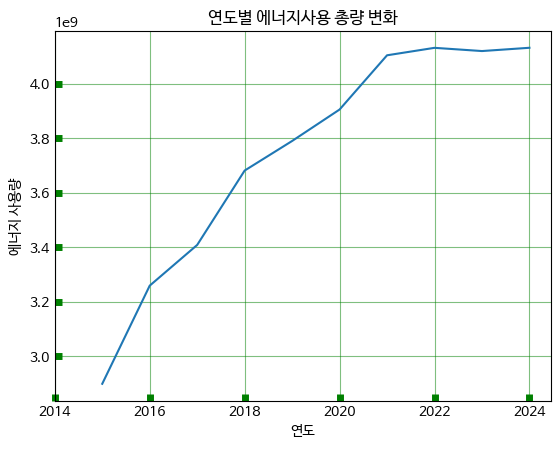

In [37]:
# 선그래프
plt.figure(figsize = (15,10))

fig, ax = plt.subplots()
ax.plot(df_year['연도'],df_year['합계'])

ax.set(xlabel='연도', ylabel='에너지 사용량', adjustable='datalim', title='연도별 에너지사용 총량 변화')
ax.set_xticks([ 2014., 2016., 2018., 2020., 2022., 2024.])
ax.tick_params(direction='in', length=5, width=5, color='g', grid_color='g', grid_alpha=0.5)
ax.grid()

fig.savefig('연도별 에너지 사용 총액 변화_6428.jpg')
plt.show()
